In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 

## Working with Tensorflow 

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../..\Classwork/input'
outDir = './output'
modelDir = './models'
subDir = 'fifa_2019'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 101 # number of epochs
ALPHA = 0.001 # learning rate
BATCH_SIZE = 32
TEST_SIZE = 0.2
REG_LAMBDA = 0.001

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [4]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))
    

In [5]:
### Settings so that Tensorflow can not Hog all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read FIFA 2019 data set

In [6]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [7]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [8]:
# Following columns appear to be relevant for our analysis
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [9]:
# Are there NaNs Still?
data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [10]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [11]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [12]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [13]:
### Weight initializer
k_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)


### regularizer
#k_reg = tf.keras.regularizers.L2(l2 = REG_LAMBDA)
k_reg = None


## dropout rate
drop1 = 0.35
drop2 = 0.25
drop3 = 0.15
drop4 = 0.05

## 33/23/12/4/4
model = tf.keras.Sequential([
    ## Input Layer
    tf.keras.layers.InputLayer(input_shape = (33,)),
    
    ## Layer 1
    tf.keras.layers.Dense(33, #activation = 'relu', 
                          kernel_initializer = k_init, kernel_regularizer = k_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(drop1),
    
    ## Layer 2
    tf.keras.layers.Dense(23, #activation = 'relu', 
                          kernel_initializer = k_init, kernel_regularizer = k_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(drop2),
    
    ## Layer 3
    tf.keras.layers.Dense(12, #activation = 'relu', 
                          kernel_initializer = k_init, kernel_regularizer = k_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(drop3),
    
    ## Layer 4
    tf.keras.layers.Dense(4, #activation = 'relu', 
                          kernel_initializer = k_init, kernel_regularizer = k_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(drop4),
    
    ## output layer
    tf.keras.layers.Dense(4)    
])

In [14]:
model(X_train[:1])

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.16922005,  0.01603629,  0.15632254,  0.11181857]],
      dtype=float32)>

In [15]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

In [16]:
model.compile(optimizer =optimizer, loss = loss_fn, metrics = ['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test,y_test) ,batch_size = BATCH_SIZE, epochs = EPOCHS, verbose=2)

Epoch 1/101


454/454 - 6s - loss: 0.7608 - accuracy: 0.7120 - val_loss: 0.4407 - val_accuracy: 0.8444 - 6s/epoch - 13ms/step
Epoch 2/101
454/454 - 2s - loss: 0.4149 - accuracy: 0.8513 - val_loss: 0.3393 - val_accuracy: 0.8658 - 2s/epoch - 5ms/step
Epoch 3/101
454/454 - 2s - loss: 0.3596 - accuracy: 0.8582 - val_loss: 0.3247 - val_accuracy: 0.8620 - 2s/epoch - 5ms/step
Epoch 4/101
454/454 - 2s - loss: 0.3399 - accuracy: 0.8631 - val_loss: 0.3060 - val_accuracy: 0.8736 - 2s/epoch - 4ms/step
Epoch 5/101
454/454 - 2s - loss: 0.3288 - accuracy: 0.8653 - val_loss: 0.3103 - val_accuracy: 0.8656 - 2s/epoch - 5ms/step
Epoch 6/101
454/454 - 2s - loss: 0.3308 - accuracy: 0.8656 - val_loss: 0.3004 - val_accuracy: 0.8749 - 2s/epoch - 5ms/step
Epoch 7/101
454/454 - 2s - loss: 0.3166 - accuracy: 0.8714 - val_loss: 0.3021 - val_accuracy: 0.8738 - 2s/epoch - 5ms/step
Epoch 8/101
454/454 - 2s - loss: 0.3163 - accuracy: 0.8719 - val_loss: 0.2982 - val_accuracy: 0.8774 - 2s/epoch - 4ms/step
Epoch 9/101
4

Epoch 64/101
454/454 - 2s - loss: 0.2679 - accuracy: 0.8868 - val_loss: 0.3138 - val_accuracy: 0.8645 - 2s/epoch - 4ms/step
Epoch 65/101
454/454 - 2s - loss: 0.2657 - accuracy: 0.8894 - val_loss: 0.3136 - val_accuracy: 0.8725 - 2s/epoch - 5ms/step
Epoch 66/101
454/454 - 2s - loss: 0.2673 - accuracy: 0.8904 - val_loss: 0.3108 - val_accuracy: 0.8752 - 2s/epoch - 4ms/step
Epoch 67/101
454/454 - 2s - loss: 0.2646 - accuracy: 0.8917 - val_loss: 0.3133 - val_accuracy: 0.8708 - 2s/epoch - 5ms/step
Epoch 68/101
454/454 - 2s - loss: 0.2646 - accuracy: 0.8899 - val_loss: 0.3091 - val_accuracy: 0.8722 - 2s/epoch - 5ms/step
Epoch 69/101
454/454 - 2s - loss: 0.2755 - accuracy: 0.8864 - val_loss: 0.3069 - val_accuracy: 0.8675 - 2s/epoch - 4ms/step
Epoch 70/101
454/454 - 2s - loss: 0.2644 - accuracy: 0.8910 - val_loss: 0.3086 - val_accuracy: 0.8730 - 2s/epoch - 4ms/step
Epoch 71/101
454/454 - 2s - loss: 0.2672 - accuracy: 0.8880 - val_loss: 0.3070 - val_accuracy: 0.8694 - 2s/epoch - 5ms/step
Epoch 72

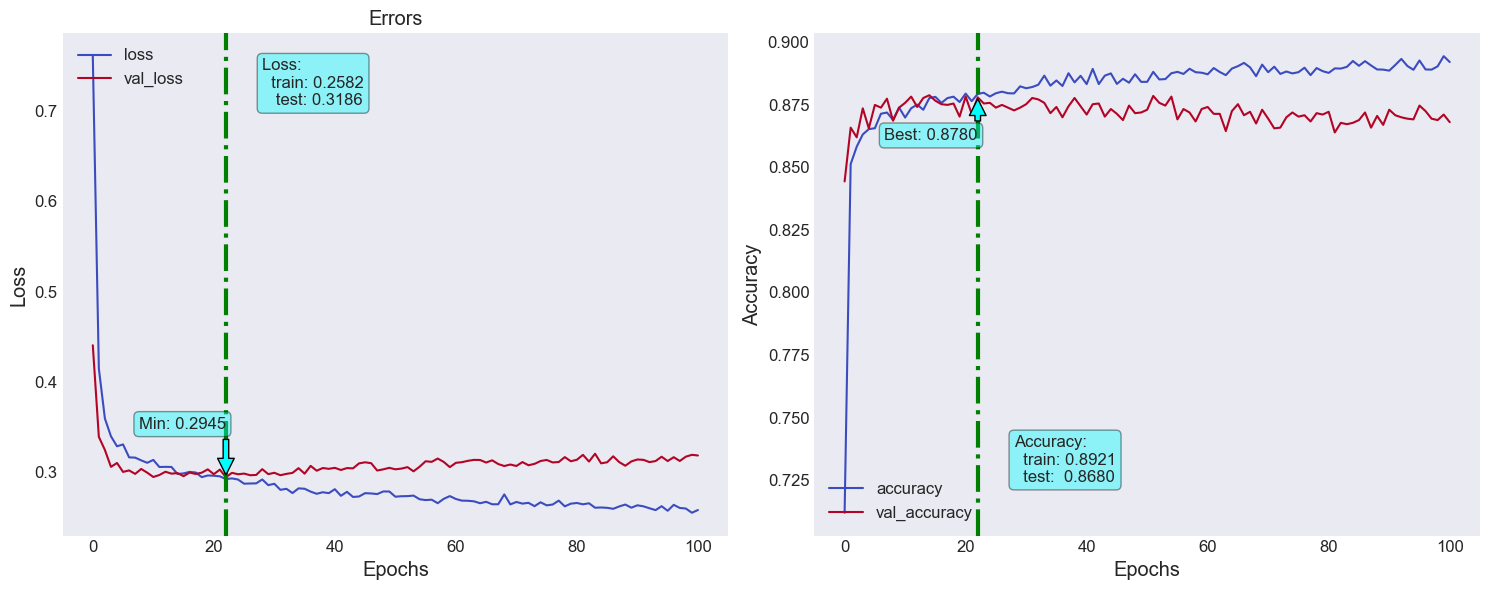

In [17]:
fn_plot_tf_hist(pd.DataFrame(history.history))